# Custom Layers in Tensorflow 2

> Custom layers give you the flexibility to implement models that use non-standard layers. In this post, we will practice uilding off of existing standard layers to create custom layers for your models. This is the summary of lecture "Custom Models, Layers and Loss functions with Tensorflow" from DeepLearning.AI.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Coursera, Tensorflow, DeepLearning.AI]
- image: images/model_simpleQuadratic.png

## Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Part 1 - Lambda Layer

In this section, it will show how you can define custom layers with the [Lambda](https://keras.io/api/layers/core_layers/lambda/) layer. You can either use [lambda functions](https://www.w3schools.com/python/python_lambda.asp) within the Lambda layer or define a custom function that the Lambda layer will call.

### Prepare the data

In [2]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train, X_test = X_train / 255.0, X_test / 255.0

### Build the model

Here, we'll use a Lambda layer to define a custom layer in our network. We're using a lambda function to get the absolute value of the layer input.

In [3]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Lambda(lambda x: tf.abs(x)),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

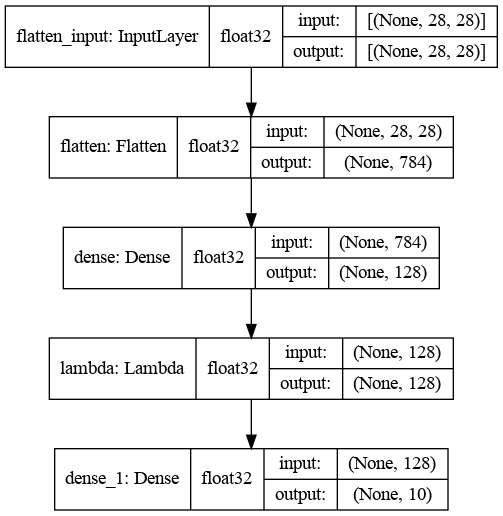

In [4]:
plot_model(model, show_layer_names=True, show_shapes=True, show_dtype=True, to_file='./image/lambda_model.png')

In [5]:
model.fit(X_train, y_train, epochs=5)
model.evaluate(X_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 2s 776us/step - loss: 0.4046 - accuracy: 0.8879
Epoch 2/5
1875/1875 [==============================] - 1s 744us/step - loss: 0.0971 - accuracy: 0.9718
Epoch 3/5
1875/1875 [==============================] - 1s 733us/step - loss: 0.0653 - accuracy: 0.9805
Epoch 4/5
1875/1875 [==============================] - 1s 735us/step - loss: 0.0480 - accuracy: 0.9848
Epoch 5/5
313/313 [==============================] - 0s 710us/step - loss: 0.0847 - accuracy: 0.9764


[0.08468984067440033, 0.9764000177383423]

Another way to use the Lambda layer is to pass in a function defined outside the model. The code below shows how a custom ReLU function is used as a custom layer in the model.

In [6]:
def my_relu(x):
    return K.maximum(-0.1, x)

model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128),
    tf.keras.layers.Lambda(my_relu), 
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
model.fit(X_train, y_train, epochs=5)
model.evaluate(X_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 2s 750us/step - loss: 0.4280 - accuracy: 0.8812
Epoch 2/5
1875/1875 [==============================] - 1s 759us/step - loss: 0.1238 - accuracy: 0.96390s - loss: 0.1259 - ac
Epoch 3/5
1875/1875 [==============================] - 1s 789us/step - loss: 0.0800 - accuracy: 0.9759
Epoch 4/5
1875/1875 [==============================] - 1s 755us/step - loss: 0.0557 - accuracy: 0.9830
Epoch 5/5
313/313 [==============================] - 0s 706us/step - loss: 0.0743 - accuracy: 0.9775


[0.07428351789712906, 0.9775000214576721]

## Part 2 - Building a Custom Dense Layer

In this section, we'll walk through how to create a custom layer that inherits the [Layer](https://keras.io/api/layers/base_layer/#layer-class) class. Unlike simple Lambda layers you did previously, the custom layer here will contain weights that can be updated during training.

### Prepare the Data

In [8]:
# define the dataset
xs = np.array([-1.0,  0.0, 1.0, 2.0, 3.0, 4.0], dtype=float)
ys = np.array([-3.0, -1.0, 1.0, 3.0, 5.0, 7.0], dtype=float)

### Custom Layer with weights

To make custom layer that is trainable, we need to define a class that inherits the [Layer](https://keras.io/api/layers/base_layer/#layer-class) base class from Keras. The Python syntax is shown below in the class declaration. This class requires three functions: `__init__()`, `build()` and `call()`. These ensure that our custom layer has a *state* and *computation* that can be accessed during training or inference.

In [9]:
from tensorflow.keras.layers import Layer

class SimpleDense(Layer):
    def __init__(self, units=32):
        '''
        Initialize the instance attributes
        '''
        super(SimpleDense, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        '''
        Create the state of the layer (weights)
        '''
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name='kernel',
                             initial_value=w_init(shape=(input_shape[-1], self.units), dtype='float32'),
                             trainable=True)
        
        # initialize bias
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name='bias',
                             initial_value=b_init(shape=(self.units,), dtype='float32'),
                             trainable=True)
        
    def call(self, inputs):
        '''
        Defines the computation from inputs to outputs
        '''
        return tf.matmul(inputs, self.w) + self.b

Now we can use our custom layer like below:

In [10]:
# declare an instance of the class
my_dense = SimpleDense(units=1)

# define an input and feed into the layer
x = tf.ones((1, 1))
y = my_dense(x)

In [11]:
# parameters of the base layer class like 'variables' can be used
my_dense.variables

[<tf.Variable 'simple_dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[0.03120579]], dtype=float32)>,
 <tf.Variable 'simple_dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]

Let's then try using it in simple network:

In [12]:
# use the Sequential API to build a model with our custom layer
my_layer = SimpleDense(units=1)
model = tf.keras.Sequential([my_layer])

# configure and train the model
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(xs, ys, epochs=500, verbose=0)

In [13]:
# perform inference
model.predict([10.0])

array([[18.981411]], dtype=float32)

In [14]:
my_layer.variables

[<tf.Variable 'simple_dense_1/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[1.9973059]], dtype=float32)>,
 <tf.Variable 'simple_dense_1/bias:0' shape=(1,) dtype=float32, numpy=array([-0.99164736], dtype=float32)>]

## Activation in a custom layer

In this section, we extend our knowledge of building custom layers by adding an activation parameter. The implementation is pretty straightforward as you'll see below.

### Prepare the Data

we'll use MNIST dataset.

### Adding an activation layer

To use the built-in activations in Keras, we can specify an `activation` parameter in the `__init__()` method of our custom layer class. From there, we can initialize it by using the `tf.keras.activations.get()` method. This takes in a string identifier that corresponds to one of the [available activations](https://keras.io/api/layers/activations/#available-activations) in Keras. Next, you can now pass in the forward computation to this activation in the `call()` method.

In [15]:
class SimpleDense(Layer):
    # add an activation paramter
    def __init__(self, units=32, activation=None):
        super(SimpleDense, self).__init__()
        self.units = units
        
        # define the activation to get from the built-in activation layers in Keras
        self.activation = tf.keras.activations.get(activation)
        
    def build(self, input_shape):
        # initialize the weight
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(name='kernel',
                             initial_value=w_init(shape=(input_shape[-1], self.units)),
                             trainable=True)
        
        # intialize the bias
        b_init = tf.zeros_initializer()
        self.b = tf.Variable(name='bias',
                             initial_value=b_init(shape=(self.units, )),
                             trainable=True)
        
    def call(self, inputs):
        # pass the computation to the activation layer
        return self.activation(tf.matmul(inputs, self.w) + self.b)

We can now pass in an activation parameter to our custom layer. The string identifier is mostly the same as the function name so 'relu' below will get `tf.keras.activations.relu`.

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    SimpleDense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

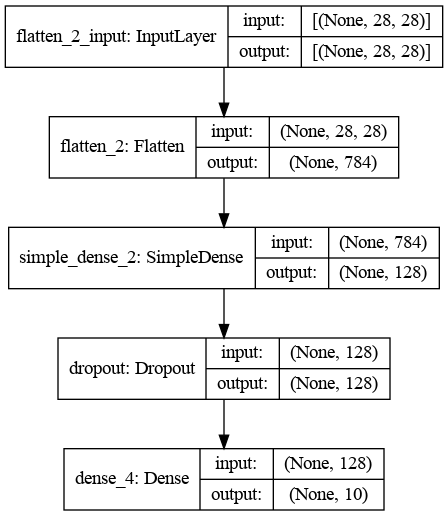

In [18]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/model_simpleDense.png')

In [19]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 753us/step - loss: 0.4704 - accuracy: 0.8634
Epoch 2/5
1875/1875 [==============================] - 1s 743us/step - loss: 0.1502 - accuracy: 0.9564
Epoch 3/5
1875/1875 [==============================] - 1s 759us/step - loss: 0.1107 - accuracy: 0.9669
Epoch 4/5
1875/1875 [==============================] - 1s 719us/step - loss: 0.0898 - accuracy: 0.9720
Epoch 5/5
1875/1875 [==============================] - 1s 762us/step - loss: 0.0721 - accuracy: 0.9773


In [20]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 742us/step - loss: 0.0743 - accuracy: 0.9752


[0.07433376461267471, 0.9751999974250793]

## Application - Implement a Quadratic Layer

In this section, you will build a custom quadratic layer which computes $y = ax^2 + bx + c$.

### Define the quadratic layer 
Implement a simple quadratic layer. It has 3 state variables: $a$, $b$ and $c$. The computation returned is $ax^2 + bx + c$. Make sure it can also accept an activation function.

#### `__init__`
- call `super(my_fun, self)` to access the base class of `my_fun`, and call the `__init__()` function to initialize that base class.  In this case, `my_fun` is `SimpleQuadratic` and its base class is `Layer`.
- self.units: set this using one of the function parameters.
- self.activation: The function parameter `activation` will be passed in as a string.  To get the tensorflow object associated with the string, please use `tf.keras.activations.get()` 


#### `build`
The following are suggested steps for writing your code.  If you prefer to use fewer lines to implement it, feel free to do so.  Either way, you'll want to set `self.a`, `self.b` and `self.c`.

- a_init: set this to tensorflow's `random_normal_initializer()`
- a_init_val: Use the `random_normal_initializer()` that you just created and invoke it, setting the `shape` and `dtype`.
    - The `shape` of `a` should have its row dimension equal to the last dimension of `input_shape`, and its column dimension equal to the number of units in the layer.  
    - This is because you'll be matrix multiplying x^2 * a, so the dimensions should be compatible.
    - set the dtype to 'float32'
- self.a: create a tensor using tf.Variable, setting the initial_value and set trainable to True.

- b_init, b_init_val, and self.b: these will be set in the same way that you implemented a_init, a_init_val and self.a
- c_init: set this to `tf.zeros_initializer`.
- c_init_val: Set this by calling the tf.zeros_initializer that you just instantiated, and set the `shape` and `dtype`
  - shape: This will be a vector equal to the number of units.  This expects a tuple, and remember that a tuple `(9,)` includes a comma.
  - dtype: set to 'float32'.
- self.c: create a tensor using tf.Variable, and set the parameters `initial_value` and `trainable`.

#### `call`
The following section performs the multiplication x^2*a + x*b + c.  The steps are broken down for clarity, but you can also perform this calculation in fewer lines if you prefer.
- x_squared: use tf.math.square()
- x_squared_times_a: use tf.matmul().  
  - If you see an error saying `InvalidArgumentError: Matrix size-incompatible`, please check the order of the matrix multiplication to make sure that the matrix dimensions line up.
- x_times_b: use tf.matmul().
- x2a_plus_xb_plus_c: add the three terms together.
- activated_x2a_plus_xb_plus_c: apply the class's `activation` to the sum of the three terms.


In [21]:
class SimpleQuadratic(Layer):

    def __init__(self, units=32, activation=None):
        '''Initializes the class and sets up the internal variables'''
        super(SimpleQuadratic, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)
    
    def build(self, input_shape):
        '''Create the state of the layer (weights)'''
        a_init = tf.random_normal_initializer()
        a_init_val = a_init(shape=(input_shape[-1], self.units),
                            dtype='float32')
        self.a = tf.Variable(name='a', 
                             initial_value=a_init_val,
                             trainable=True)
        
        b_init = tf.random_normal_initializer()
        b_init_val = b_init(shape=(input_shape[-1], self.units),
                            dtype='float32')
        self.b = tf.Variable(name='b',
                             initial_value=b_init_val,
                             trainable=True)
        
        c_init = tf.zeros_initializer()
        c_init_val = c_init(shape=(self.units, ),
                            dtype='float32')
        self.c = tf.Variable(name='c',
                            initial_value=c_init_val,
                             trainable=True)
        super().build(input_shape)
        
   
    def call(self, inputs):
        '''Defines the computation from inputs to outputs'''
        x_squared = tf.math.square(inputs)
        x_squared_times_a = tf.matmul(x_squared, self.a)
        x_times_b = tf.matmul(inputs, self.b)
        x2a_plus_xb_plus_c = x_squared_times_a + x_times_b + self.c
        activated_x2a_plus_xb_plus_c = self.activation(x2a_plus_xb_plus_c)
        return activated_x2a_plus_xb_plus_c

Train your model with the `SimpleQuadratic` layer that you just implemented.

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    SimpleQuadratic(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

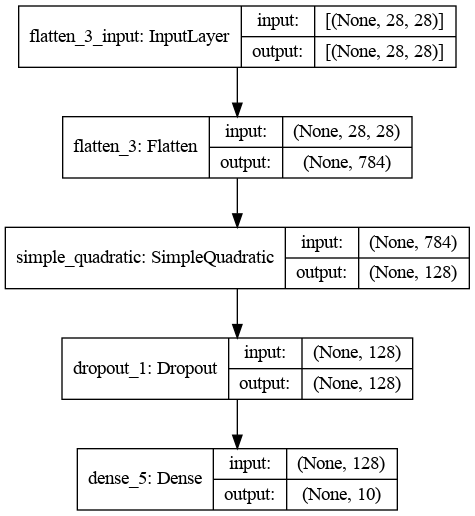

In [23]:
plot_model(model, show_shapes=True, show_layer_names=True, to_file='./image/model_simpleQuadratic.png')

In [24]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 972us/step - loss: 0.4291 - accuracy: 0.8678
Epoch 2/5
1875/1875 [==============================] - 2s 1ms/step - loss: 0.1362 - accuracy: 0.9589
Epoch 3/5
1875/1875 [==============================] - 2s 883us/step - loss: 0.1015 - accuracy: 0.9683
Epoch 4/5
1875/1875 [==============================] - 1s 765us/step - loss: 0.0800 - accuracy: 0.9743
Epoch 5/5
1875/1875 [==============================] - 1s 755us/step - loss: 0.0702 - accuracy: 0.9772


In [25]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 700us/step - loss: 0.0779 - accuracy: 0.9775


[0.07792823016643524, 0.9775000214576721]